In [1]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib import pyplot as plt
from theano import shared as tshared
import theano.tensor as tt

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev

In [2]:
# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)

In [3]:
data['y']

array([592., 401., 583., 402., 495., 173., 479., 504., 510., 416., 393.,
       442., 317., 311., 400., 337., 423., 334., 533., 344.])

In [4]:
matched_z=pd.read_pickle("final_mcxc_cat_6_3.pkl")
matched_z

,index,recno,MCXC,RAJ2000,DEJ2000,z,L500,M500,R500,Notes,...,rich,idx,d2d,match,Redmapper z,MCXC z,Z_err,Redmapper RA,Redmapper DEC,Redmapper Lambda
10,1071,1072,J1401.0+0252,14 01 02.3,+02 52 48,0.2528,19.721872,10.4956,1.4189,,...,97.099297,33,0.000311,86,0.257090,0.2528,0.007981,210.252200,2.863809,134.278503
14,674,675,J1023.6+0411,10 23 38.8,+04 11 11,0.2850,18.098963,9.7115,1.3664,,...,92.211796,469,0.000138,1378,0.291733,0.2850,0.011069,155.919481,4.187515,73.533188
15,799,800,J1149.5+2224,11 49 35.3,+22 24 09,0.5450,14.471760,9.3427,1.2200,,...,93.345109,178,0.000075,3,0.535517,0.5450,0.014635,177.398695,22.398499,231.040802
19,1573,1574,J2153.5+1741,21 53 35.5,+17 41 12,0.2329,14.814972,8.9525,1.3554,,...,86.049082,23,0.000182,51,0.250578,0.2329,0.007688,328.403462,17.695479,145.841766
22,1261,1262,J1640.3+4642,16 40 21.4,+46 42 21,0.2280,14.053749,8.7019,1.3450,,...,84.191939,1,0.000152,4,0.232764,0.2280,0.006156,250.082548,46.711531,199.539276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,874,875,J1227.2+0858,12 27 14.2,+08 58 15,0.0873,0.116484,0.5192,0.5517,,...,10.249846,180,0.000054,1957,0.089199,0.0873,0.005257,186.812240,8.970866,66.561668
1539,559,560,J0900.0+3920,09 00 04.8,+39 20 24,0.0951,0.116947,0.5176,0.5497,,...,10.242728,2138,0.000156,17240,0.090436,0.0951,0.005861,135.021507,39.331194,28.225916
1551,148,149,J0144.4+0212,01 44 29.1,+02 12 37,0.1660,0.117979,0.4944,0.5286,WARPS1,...,10.040517,6133,0.000050,20653,0.168224,0.1660,0.004903,26.123694,2.208745,24.747782
1573,1040,1041,J1343.4+4053,13 43 25.0,+40 53 14,0.1400,0.097808,0.4495,0.5166,,...,9.313140,17036,0.000048,24607,0.259710,0.1400,0.010632,205.856738,40.888238,21.345922


In [5]:
xi=tshared(np.array(matched_z['Redmapper z']))
yi=tshared(np.array(matched_z['MCXC z']))
dyi=tshared(np.array(matched_z['Z_err']))
size=len(matched_z)

In [6]:
# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept

In [7]:
# ----------------------------------------------------------------------
# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1, 1)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    y = pm.Normal('y', mu=model(xi, theta, inter), sd=dyi, observed=yi)

    trace0 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al

def mixture_likelihood(yi, xi):
#    """Equation 17 of Hogg 2010"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10, 10, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -1, 1, testval=0)

    inter = pm.Uniform('inter', -1, 1)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)

def outlier_likelihood(yi, xi):
    """likelihood for full outlier posterior"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    logL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi) + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb)) + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10, 10, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -1, 1, testval=0)

    inter = pm.Uniform('inter', -1, 1)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distributed
    qi = pm.Bernoulli('qi', p=1 - Pb, shape=size)

    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood, observed={'yi': yi, 'xi': xi})

    trace2 = pm.sample(draws=5000, tune=1000)


<ipython-input-7-57c552449a9a>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace0 = pm.sample(draws=5000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, inter]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8852812849430284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855676084484355, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-7-57c552449a9a>:52: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace1 = pm.sample(draws=5000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, inter, log_sigmab, Yb, Pb]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.9075410363020991, but should be close to 0.8. Try to increase the number of tuning steps.
<ipython-input-7-57c552449a9a>:93: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace2 = pm.sample(draws=5000, tune=1000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, inter, log_sigmab, Yb, Pb]
>BinaryGibbsMetropolis: [qi]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 166 seconds.
/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Text(0, 0.5, '$y$')

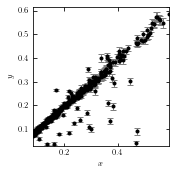

In [8]:
# ------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(matched_z['Redmapper z'], matched_z['MCXC z'], matched_z['Z_err'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

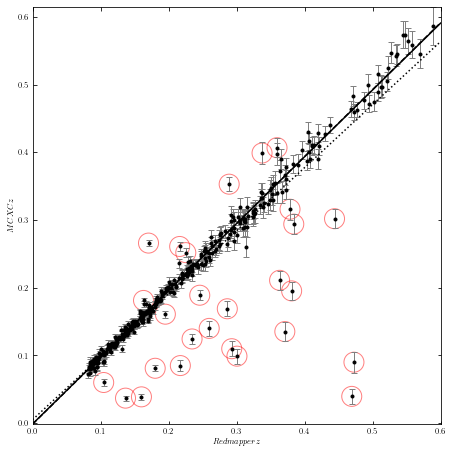

In [9]:
# ------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(matched_z['Redmapper z'], matched_z['MCXC z'], matched_z['Z_err'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$Redmapper z$')
ax1.set_ylabel('$MCXC z$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']

x = np.linspace(0, 0.6, 10)

for i, trace in enumerate([trace0, trace1, trace2]):
    H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                       trace['inter'], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        Pi = trace['qi'].mean(0)
        outlier_x = matched_z['Redmapper z'][Pi < 0.32]
        outlier_y = matched_z['MCXC z'][Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

#ax1.set_xlim(0, 350)
#ax1.set_ylim(100, 700)

plt.show()

In [ ]:
outliers=matched_z[Pi<0.32]
outliers

In [ ]:
outliers.to_pickle('mcxc_outliers_6_3.pkl')

In [ ]:
notoutliers=matched_z[Pi>=0.32]
notoutliers

In [ ]:
notoutliers.to_pickle('mcxc_notoutliers_6_3.pkl')